In [78]:
import numpy as np
import math
import random as r
import pylab
import matplotlib.pyplot as plt
from numba import jit

## Sign function
sign = lambda x : math.copysign(1,x)

N = 10
N2 = N**2


In [79]:
@jit(nopython=True)
def CEnergy(latt, N):
    Ene = 0
    for i in range(N):
        for j in range(N):
            S = latt[i,j]
            WF = latt[i, (j+1)%N] + latt[i, (j-1)%N] + latt[(i+1)%N, j] + latt[(i-1)%N, j]
            Ene += -S*WF
    return int(Ene/2.)

def RandomL(N):
    latt = np.zeros((N,N), dtype=int)
    for i in range(N):
        for j in range(N):
            latt[i,j] = sign(2*r.random() - 1)
    return latt

In [80]:
def MCMC(Nitt, N, T):
    Aven = 0.0
    latt = RandomL(N)
    print(f"lattice: {latt}")
    Ene = CEnergy(latt, N)
    density = np.zeros(N*N+1, dtype=int).tolist() #keep track of energy values
    for i in range(Nitt):
        ii = int(r.random()*100)
        (i,j) = (ii%N, ii//N)
        S = latt[i,j]
        WF = latt[i, (j+1)%N] + latt[i, (j-1)%N] + latt[(i+1)%N, j] + latt[(i-1)%N, j]
        Enew = Ene + 2*S*WF
        P = min(1, math.exp((Ene-Enew)/T))
        if P > r.random(): #metropolis condition
            latt[i,j] = -S #flip the state of lattice
            Ene = Enew #update energy
        density[50+Ene//4] += 1 #update density of states
        Aven += Ene
    return (density, Aven/Nitt) # return the dos and avg energy for the given temperature

Energies = (4*np.arange(N2+1)-2*N2).tolist()


In [81]:
def ferrenberg_swendsen(Energies, densities, temperatures, tol=1e-6, max_iter=500):
    """
    Energies:       array of energies (same for all runs)
    densities:      list of histograms (each is an array of length len(Energies))
    temperatures:   list or array of temperatures, one per histogram
    Returns:
        gE: microcanonical density of states (unnormalized)
        fi: list of partition function estimates at simulation temperatures
    """
    densities = [np.array(d) for d in densities]
    Energies = np.array(Energies)
    temperatures = np.array(temperatures)
    n_temps = len(temperatures)
    n_energies = len(Energies)

    # Convert densities to numpy array
    densities = np.array(densities)  # shape (n_temps, n_energies)
    N_i = densities.sum(axis=1)      # total counts at each T

    # Initialize fi
    fi = np.ones(n_temps)
    gE = np.ones(n_energies)
    last_gE = np.ones(n_energies)
    
    for iteration in range(max_iter):
        # Update gE
        numer = densities.sum(axis=0)
        denom = np.zeros(n_energies)
        for i in range(n_temps):
            denom += np.exp(-Energies/temperatures[i]) / (N_i[i] * fi[i])
        gE = numer / np.clip(denom, 1e-30, np.inf)  # avoid divide by zero

        # Update fi
        for i in range(n_temps):
            fi[i] = np.sum(gE * np.exp(-Energies/temperatures[i]))

        # Convergence check
        if np.max(np.abs(gE - last_gE) / (last_gE + 1e-15)) < tol:
            print(f"FS converged after {iteration} iterations.")
            break
        last_gE = gE.copy()
    else:
        print("Warning: FS did not converge.")
    return gE, fi

lattice: [[-1 -1  1  1  1  1 -1 -1 -1  1]
 [ 1  1 -1 -1 -1 -1 -1  1  1  1]
 [ 1  1 -1  1 -1  1 -1 -1 -1  1]
 [ 1 -1 -1 -1 -1 -1  1  1  1 -1]
 [ 1  1 -1 -1 -1  1 -1  1  1 -1]
 [ 1  1 -1  1  1  1 -1 -1  1 -1]
 [ 1 -1 -1 -1  1  1  1  1  1  1]
 [ 1  1  1  1 -1  1 -1 -1 -1  1]
 [ 1  1 -1 -1  1 -1  1  1 -1  1]
 [ 1 -1  1 -1 -1  1  1  1 -1  1]]


<Figure size 800x600 with 0 Axes>

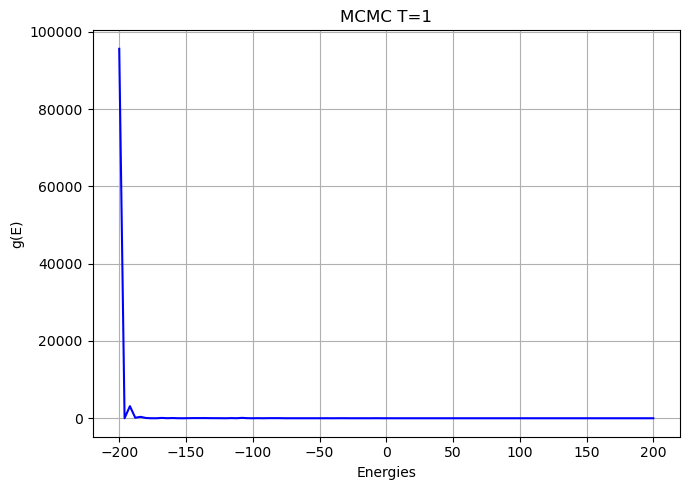

lattice: [[-1  1 -1  1  1 -1 -1  1  1 -1]
 [ 1 -1  1 -1  1  1  1 -1  1  1]
 [ 1 -1 -1 -1 -1 -1  1 -1 -1  1]
 [-1  1  1  1  1  1  1 -1  1 -1]
 [ 1 -1  1  1 -1 -1  1 -1 -1 -1]
 [ 1  1 -1  1  1 -1 -1  1 -1  1]
 [-1  1  1  1  1  1 -1 -1  1  1]
 [ 1 -1 -1 -1 -1  1  1  1 -1 -1]
 [ 1 -1  1  1 -1 -1  1  1  1 -1]
 [-1 -1  1 -1  1  1  1  1 -1  1]]


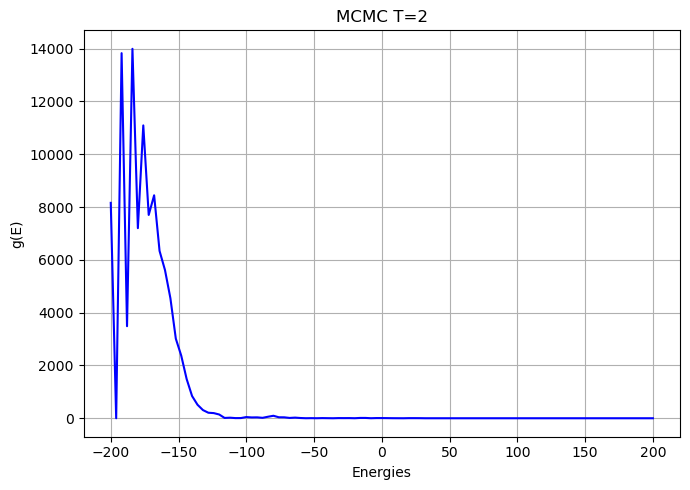

lattice: [[-1  1  1  1  1 -1  1  1 -1  1]
 [ 1 -1 -1 -1  1 -1 -1 -1 -1  1]
 [ 1  1  1  1  1  1 -1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1 -1]
 [ 1  1  1 -1 -1 -1 -1 -1  1  1]
 [-1 -1  1  1  1  1  1  1  1  1]
 [-1 -1 -1 -1  1 -1  1 -1 -1 -1]
 [-1  1  1 -1 -1 -1  1  1  1 -1]
 [-1 -1 -1  1 -1 -1 -1  1 -1  1]
 [-1  1  1 -1  1 -1 -1  1 -1  1]]


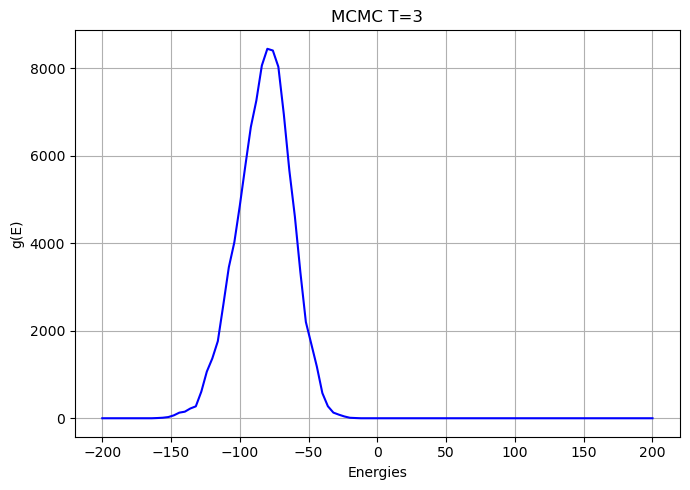

lattice: [[ 1 -1 -1 -1  1 -1 -1  1 -1 -1]
 [-1  1  1  1  1  1 -1 -1 -1  1]
 [ 1 -1 -1  1  1  1 -1 -1  1  1]
 [-1 -1 -1  1  1 -1  1 -1  1 -1]
 [-1  1 -1 -1 -1  1  1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1  1  1  1  1]
 [ 1 -1  1  1 -1  1 -1  1 -1 -1]
 [-1  1  1 -1 -1 -1  1 -1 -1 -1]
 [-1  1 -1  1  1  1  1 -1  1  1]
 [ 1  1  1 -1 -1  1  1 -1 -1  1]]


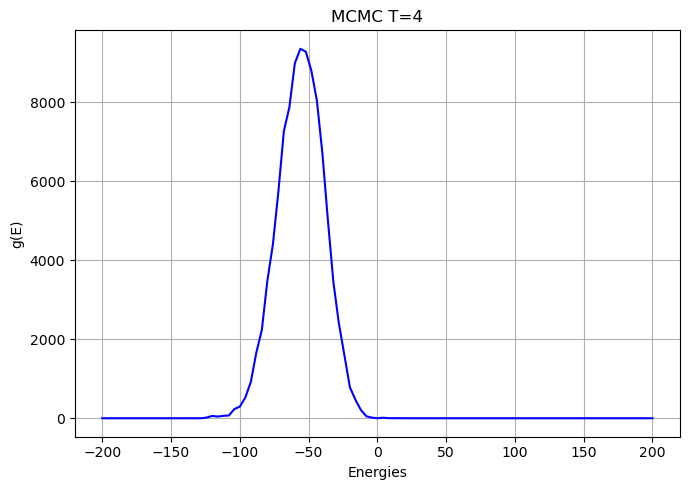

lattice: [[-1 -1 -1 -1  1  1  1  1 -1 -1]
 [ 1  1  1 -1  1 -1 -1 -1  1 -1]
 [-1  1  1 -1  1 -1 -1  1 -1 -1]
 [-1 -1  1 -1 -1  1 -1  1  1  1]
 [-1 -1  1  1  1 -1 -1  1  1  1]
 [-1 -1 -1 -1  1  1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  1]
 [-1 -1 -1 -1 -1  1 -1  1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1  1  1 -1]
 [-1  1 -1 -1 -1  1  1  1  1  1]]


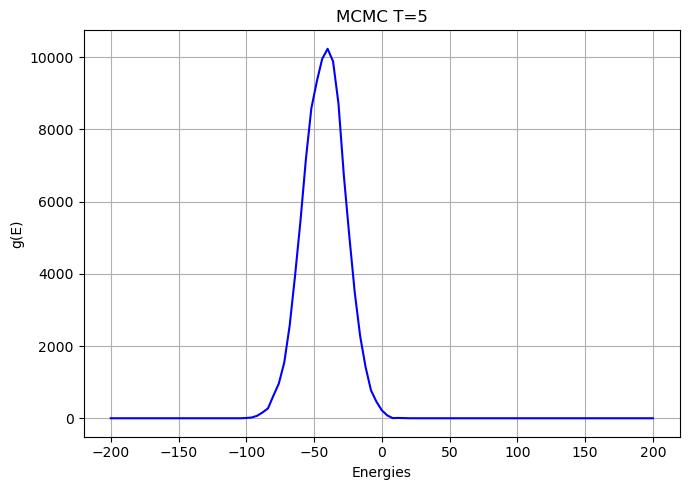

lattice: [[ 1  1 -1 -1  1  1 -1 -1  1  1]
 [ 1  1 -1  1  1  1  1 -1 -1  1]
 [-1 -1 -1 -1 -1 -1  1 -1 -1 -1]
 [-1 -1 -1  1  1 -1  1  1 -1  1]
 [-1 -1 -1 -1 -1 -1  1 -1 -1  1]
 [ 1  1 -1 -1 -1 -1 -1  1  1 -1]
 [-1  1  1 -1 -1 -1  1  1 -1  1]
 [-1 -1 -1  1  1  1 -1  1 -1 -1]
 [-1 -1  1  1 -1  1 -1 -1 -1 -1]
 [-1 -1  1  1  1 -1 -1  1  1 -1]]


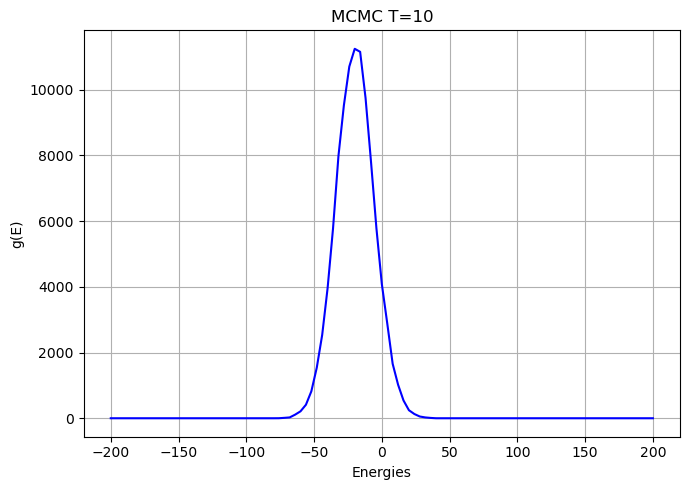

lattice: [[-1 -1  1  1  1 -1  1  1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1  1  1]
 [ 1  1 -1 -1  1  1  1 -1 -1  1]
 [-1 -1 -1  1 -1  1  1  1 -1 -1]
 [ 1  1 -1  1  1  1 -1 -1  1  1]
 [ 1  1  1  1  1  1  1 -1 -1  1]
 [-1  1  1 -1  1 -1  1 -1  1 -1]
 [-1  1  1 -1 -1 -1  1 -1 -1  1]
 [-1 -1  1  1  1 -1 -1  1 -1 -1]
 [ 1 -1 -1  1 -1  1 -1 -1 -1  1]]


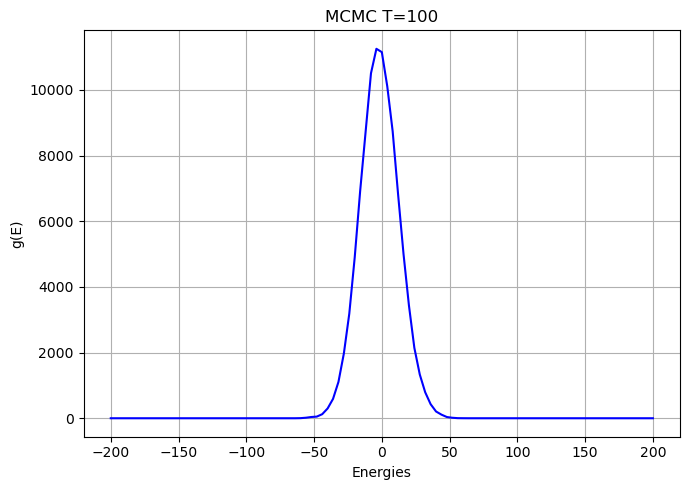

In [82]:
Nitt = int(1e5)
temps = [1, 2, 3, 4, 5, 10, 100]
plt.figure(figsize=(8,6))
for idx, T in enumerate(temps):
    density, avg_E  = MCMC(Nitt, N, T)
    plt.figure(figsize=(7,5))
    plt.plot(Energies , density, 'b')
    plt.xlabel('Energies')
    plt.ylabel('g(E)')
    plt.title(f'MCMC T={T}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

lattice: [[ 1 -1  1 -1 -1  1 -1  1 -1  1]
 [-1 -1 -1  1 -1 -1 -1 -1 -1  1]
 [ 1  1  1  1  1  1  1 -1 -1  1]
 [-1 -1  1  1  1  1  1  1 -1  1]
 [ 1 -1  1 -1  1  1  1  1 -1  1]
 [-1 -1  1  1  1  1 -1 -1  1 -1]
 [-1  1  1 -1 -1  1  1 -1 -1 -1]
 [-1  1 -1  1 -1 -1 -1  1 -1  1]
 [-1 -1 -1 -1 -1 -1 -1 -1  1 -1]
 [ 1 -1 -1 -1  1 -1 -1  1  1  1]]


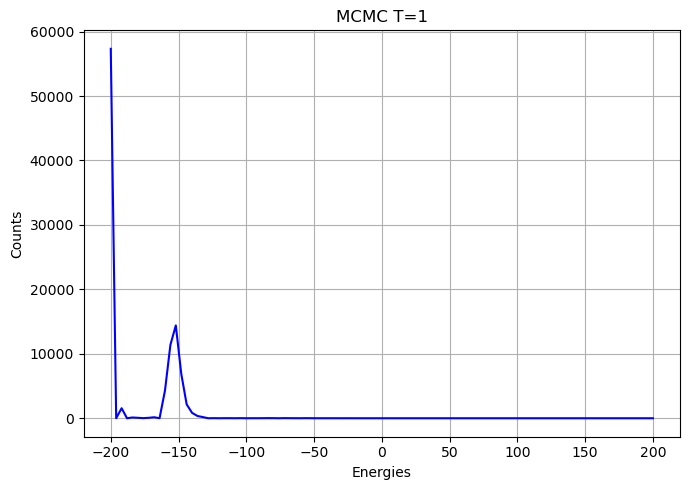

lattice: [[-1 -1  1  1  1  1  1 -1  1 -1]
 [-1  1  1  1 -1 -1 -1  1  1 -1]
 [-1  1 -1 -1  1 -1 -1 -1 -1  1]
 [ 1 -1  1 -1  1  1  1 -1  1  1]
 [ 1 -1 -1 -1 -1 -1  1  1 -1  1]
 [ 1  1  1 -1  1 -1 -1  1 -1  1]
 [ 1  1  1 -1 -1  1  1  1  1 -1]
 [-1  1 -1 -1  1  1 -1 -1 -1  1]
 [ 1 -1  1 -1 -1 -1 -1 -1 -1  1]
 [-1 -1  1 -1 -1 -1 -1  1  1 -1]]


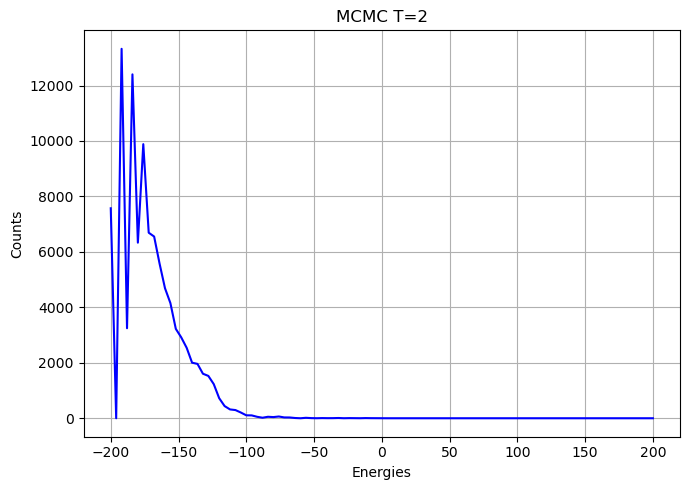

lattice: [[ 1  1  1 -1 -1 -1 -1  1  1  1]
 [-1  1 -1 -1 -1  1 -1  1  1 -1]
 [-1 -1  1 -1 -1 -1  1 -1  1 -1]
 [ 1  1 -1 -1  1  1  1  1  1 -1]
 [ 1  1 -1  1  1  1 -1 -1  1 -1]
 [-1  1 -1 -1 -1  1 -1  1  1  1]
 [-1 -1 -1 -1  1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1  1  1  1]
 [-1 -1 -1  1  1 -1  1 -1 -1 -1]
 [-1  1 -1  1 -1 -1 -1  1 -1 -1]]


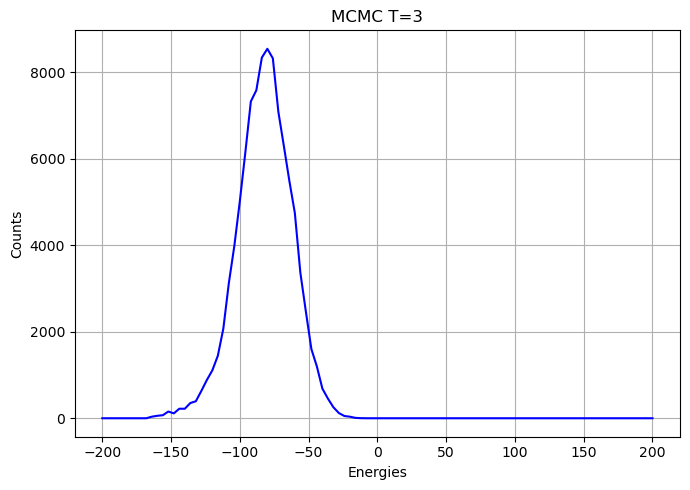

lattice: [[ 1 -1 -1  1 -1 -1  1 -1 -1 -1]
 [ 1 -1 -1 -1  1 -1  1 -1 -1  1]
 [-1 -1 -1  1  1  1 -1  1 -1  1]
 [-1  1 -1  1 -1  1  1 -1 -1 -1]
 [ 1 -1 -1  1 -1 -1  1  1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1  1  1 -1]
 [ 1  1 -1 -1  1  1 -1  1  1 -1]
 [ 1 -1 -1 -1 -1 -1  1 -1  1  1]
 [ 1  1  1  1  1  1  1  1  1 -1]
 [-1  1 -1  1  1  1 -1  1 -1  1]]


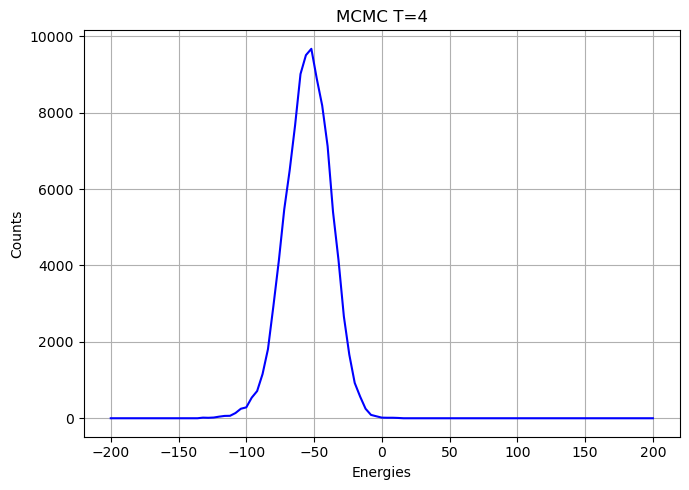

lattice: [[ 1  1  1  1 -1  1 -1  1  1  1]
 [-1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1  1  1  1  1  1  1  1 -1 -1]
 [-1 -1 -1  1 -1  1 -1 -1  1  1]
 [-1  1 -1 -1  1 -1 -1 -1 -1  1]
 [-1  1 -1  1  1  1  1 -1 -1 -1]
 [-1  1  1 -1 -1  1  1 -1 -1 -1]
 [ 1 -1  1  1  1  1  1  1 -1 -1]
 [-1  1 -1  1  1  1 -1  1  1 -1]
 [ 1  1 -1 -1  1 -1 -1 -1  1 -1]]


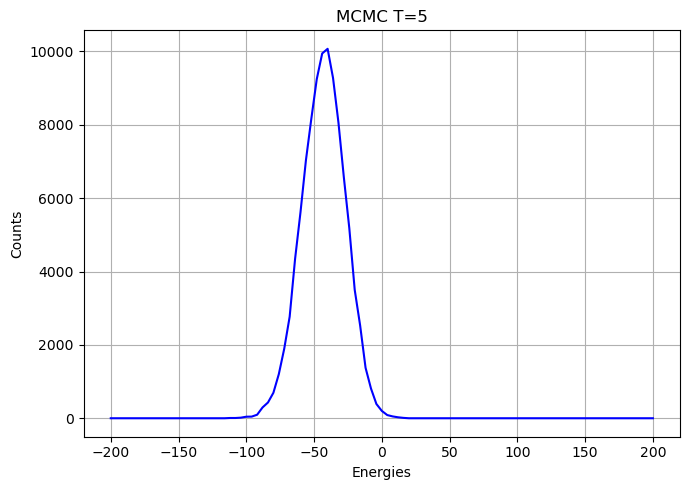

lattice: [[ 1  1  1  1  1 -1  1 -1 -1  1]
 [ 1 -1  1 -1 -1  1  1  1  1  1]
 [-1  1 -1 -1  1 -1 -1  1  1  1]
 [ 1  1 -1 -1 -1 -1  1 -1  1 -1]
 [ 1  1 -1  1  1 -1 -1 -1  1 -1]
 [-1  1 -1 -1  1  1  1  1  1 -1]
 [-1 -1  1  1 -1  1  1  1 -1 -1]
 [ 1  1 -1 -1 -1 -1  1 -1  1  1]
 [ 1 -1  1  1  1 -1 -1  1  1 -1]
 [ 1  1  1  1  1  1  1  1  1  1]]


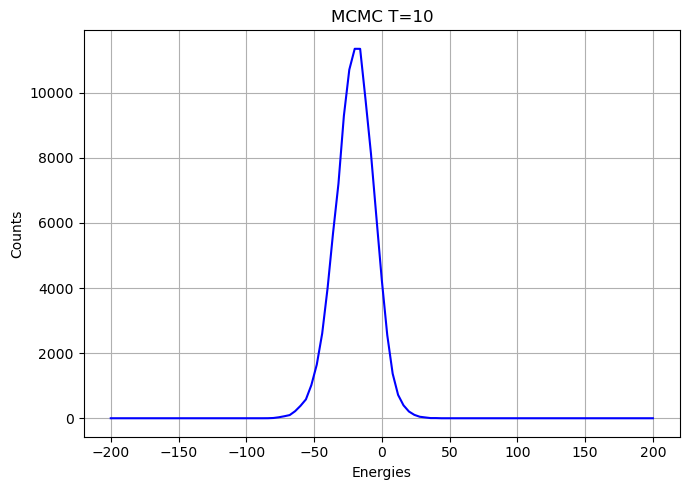

lattice: [[-1  1  1  1  1  1 -1 -1  1  1]
 [-1 -1 -1 -1 -1 -1  1  1  1  1]
 [-1 -1 -1 -1 -1 -1  1  1  1  1]
 [-1  1  1 -1  1  1  1  1 -1  1]
 [ 1 -1  1  1 -1 -1  1  1 -1 -1]
 [-1  1 -1  1 -1  1 -1 -1 -1 -1]
 [-1 -1  1  1 -1  1  1 -1  1 -1]
 [ 1  1  1 -1  1 -1 -1 -1 -1  1]
 [-1  1 -1 -1  1  1 -1  1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1  1  1]]


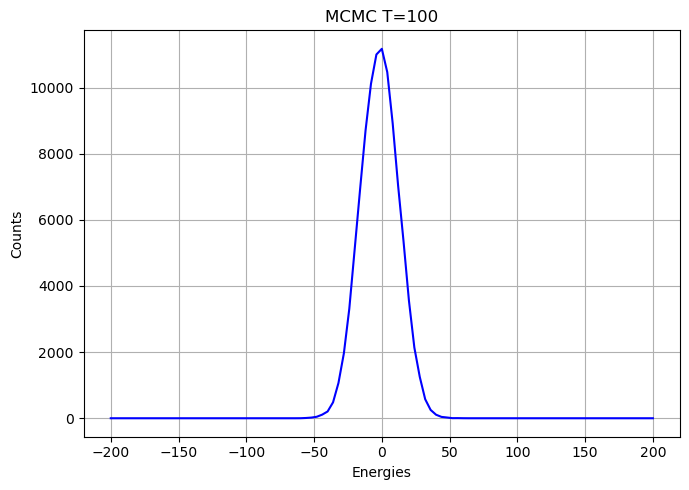

ValueError: Integers to negative integer powers are not allowed.

In [83]:
Nitt = int(1e5)
temps = [1, 2, 3, 4, 5, 10, 100]
all_densities = []
all_avg_E = []

for T in temps:
    density, avg_E  = MCMC(Nitt, N, T)
    all_densities.append(density)
    all_avg_E.append(avg_E)
    plt.figure(figsize=(7,5))
    plt.plot(Energies , density, 'b')
    plt.xlabel('Energies')
    plt.ylabel('Counts')
    plt.title(f'MCMC T={T}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Ferrenberg-Swendsen estimation ---
gE, fi = ferrenberg_swendsen(Energies, all_densities, temps)

# Partition function at any T:
Tvals = np.linspace(1, 5, 100)
Zvals = [np.sum(gE * np.exp(-np.array(Energies)/T)) for T in Tvals]

plt.figure(figsize=(8,5))
plt.plot(Tvals, Zvals)
plt.xlabel("T")
plt.ylabel("Partition function Z(T)")
plt.title("Partition function estimated via Ferrenberg–Swendsen")
plt.grid(True)
plt.tight_layout()
plt.show()
